# Расчет RWA

In [8]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
from scipy.stats import norm

import matplotlib.pylab as plt

Сounterparties

In [9]:
d = pd.DataFrame()
d['nominal'] = [100, 17000, 1000, 300000, 670, 2300, 8000]
d['cnt'] = [10, 35, 400, 1, 300, 100, 164]
d['rating'] = [21, 15, 12, 9, 18, 15, 11]
d

,nominal,cnt,rating
0,100,10,21
1,17000,35,15
2,1000,400,12
3,300000,1,9
4,670,300,18
5,2300,100,15
6,8000,164,11


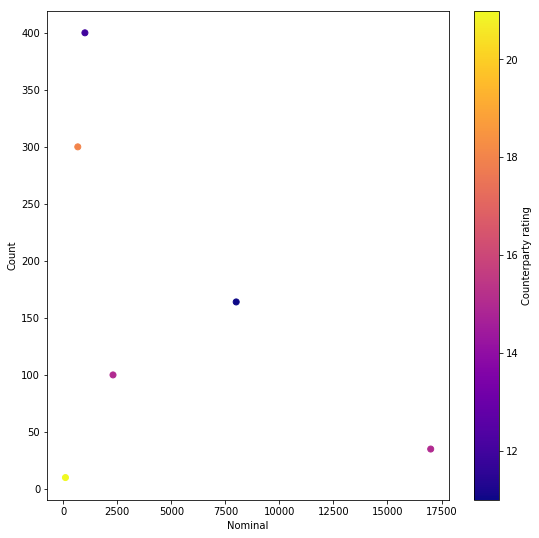

In [51]:
tmp = d[d['nominal'] < 300000]

cm = plt.cm.get_cmap('plasma')
plt.figure(figsize=(9, 9))
plt.scatter(tmp['nominal'], tmp['cnt'], c=tmp['rating'], cmap=cm)
plt.colorbar( label='Сounterparty rating')
plt.ylabel('Count')
plt.xlabel('Nominal')
plt.show()

Sum by nominal

In [11]:
d['sum'] = d['nominal'] * d['cnt']
d

,nominal,cnt,rating,sum
0,100,10,21,1000
1,17000,35,15,595000
2,1000,400,12,400000
3,300000,1,9,300000
4,670,300,18,201000
5,2300,100,15,230000
6,8000,164,11,1312000


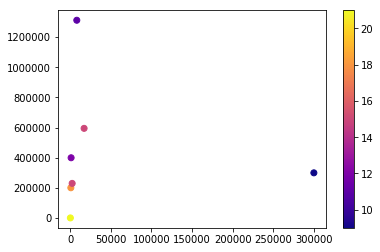

In [12]:
plt.scatter(d['nominal'], d['sum'], c=d['rating'], cmap=cm)
plt.colorbar()
plt.show()

Sorting sums by nominal

In [13]:
tmp = d[['nominal', 'sum', 'rating']].sort_values('nominal')
tmp

,nominal,sum,rating
0,100,1000,21
4,670,201000,18
2,1000,400000,12
5,2300,230000,15
6,8000,1312000,11
1,17000,595000,15
3,300000,300000,9


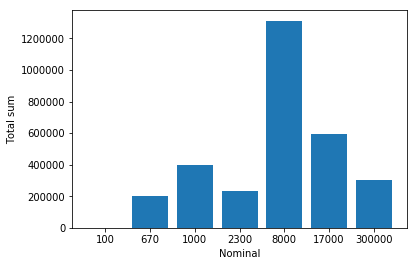

In [14]:
tick_label = tmp['nominal'].astype(str).tolist()
plt.bar(list(range(len(tmp))), tmp['sum'], tick_label=tick_label)
plt.ylabel('Total sum')
plt.xlabel('Nominal')
plt.show()

In [15]:
tmp = d[['nominal','cnt','rating']].sort_values('nominal')
tmp

,nominal,cnt,rating
0,100,10,21
4,670,300,18
2,1000,400,12
5,2300,100,15
6,8000,164,11
1,17000,35,15
3,300000,1,9


C:\Pythonnnn\secondPython\lib\site-packages\matplotlib\__init__.py:1717: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


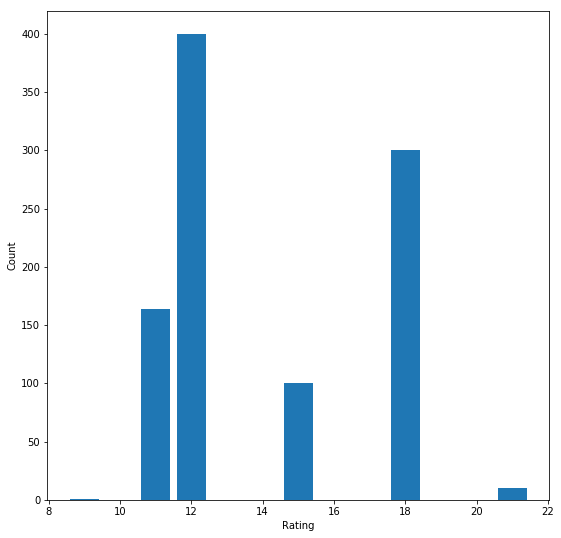

In [52]:
plt.figure(figsize=(9, 9))
plt.bar(left=d['rating'], height=d['cnt'])
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

Используем стандартизированный подход (стр. 7)

https://www.bis.org/bcbs/publ/d424_hlsummary.pdf 

In [53]:
def weight(rating):
    if rating < 3 : return 0.2
    if rating < 7 : return 0.5
    if rating < 13 : return 1.0
    return 1.5

d['rweighted'] = d['sum'] * d['rating'].map(weight)
d

,nominal,cnt,rating,sum,rweighted,PD,MatAdj,Corr,UL,RWA,EL,MaturityAdj
0,100,10,21,1000,1500.0,0.421799,0.027492,0.120000,188.788748,2359.859344,189.80955,0.027492
1,17000,35,15,595000,892500.0,0.032453,0.093822,0.143685,62498.396022,781229.950271,8689.29075,0.093822
2,1000,400,12,400000,400000.0,0.008882,0.142345,0.196968,28283.294926,353541.186573,1598.76000,0.142345
3,300000,1,9,300000,300000.0,0.002389,0.201799,0.226489,11591.398661,144892.483259,322.51500,0.201799
4,670,300,18,201000,301500.0,0.111534,0.056966,0.120454,32306.266455,403828.330683,10088.25030,0.056966
5,2300,100,15,230000,345000.0,0.032453,0.093822,0.143685,24159.043840,301988.048004,3358.88550,0.093822
6,8000,164,11,1312000,1312000.0,0.005739,0.160970,0.210066,77687.549778,971094.372224,3388.30560,0.160970


In [54]:
print('RWA = ', d['rweighted'].sum())

RWA =  3552500.0


# Расчета величины кредитного риска на основе внутренних рейтингов

Параметры: 

PD – вероятность дефолта заемщика на период в один год.

LGD – уровень потерь при дефолте, определяемый как доля потерь в величине кредитного требования.
на момент возможного дефолта.

М – срок до погашения кредитного требования(в общем случае).

R – значение показателя корреляции.

EAD(Exposure At Default) - требования под риском дефолта (на момент дефолта).

RWA - взвешенные по рискам активы.


Функции:

maturityAdjustment(PD) – корректировка на срок до погашения, как функция от PD.

correlation(PD) -  корреляциия, как функция от PD.

norm.cdf(PD) - функция стандартного нормального распределения.

norm.ppf(PD) - обратная функция стандартного нормального распределения.

http://ivo.garant.ru/#/document/71203444/paragraph/144:0  - ЦБ РФ 483-П

In [55]:
M = 2.5
LGD = 0.45

def maturityAdjustment(PD):
    return (0.11852 - 0.05478 * math.log(PD))**2 

def correlation(PD):
    return 0.12 * (1 - math.exp(-50 * PD)) / (1 - math.exp(-50)) + 0.24 * (1 - (1 - math.exp(-50 * PD)) / (1 - math.exp(-50)))
 
def capitalRequirement(PD, LGD):
    b = maturityAdjustment(PD)
    R = correlation(PD)
    normPd = (norm.ppf(PD) + R**0.5 * norm.ppf(0.999)) / ((1 - R)**0.5) 
    normLgd = LGD * (norm.cdf(normPd)- PD)
    return normLgd * (1 + (M - 2.5) * b) /  (1 - 1.5 * b)  

def RWA(PD, LGD, EAD):
    K = capitalRequirement(PD, LGD)
    return K * 12.5 * EAD

Будем использовать подход к оценке PD, использованный:
http://d.rmicri.org/static/pdf/Probability%20of%20Default%20Implied%20Rating%20White%20Paper.pdf

Возьмем, для примера только интересующие нас rating.

In [56]:
import pandas as pd
pdWp = pd.DataFrame()
pdWp['category'] = ['BBB', 'BB', 'BB+', 'B', 'CCC', 'C']
pdWp['rate'] = [23.89, 57.39, 88.82, 324.53, 1115.34, 4217.99]
pdWp

,category,rate
0,BBB,23.89
1,BB,57.39
2,BB+,88.82
3,B,324.53
4,CCC,1115.34
5,C,4217.99


pdInBp(rating) - pd, как функция от rating

In [22]:
def pdInBp(rating):
    if rating == 9 : return 23.89
    if rating == 11 : return 57.39
    if rating == 12 : return 88.82
    if rating == 15 : return 324.53
    if rating == 18 : return 1115.34
    if rating == 21 : return 4217.99
    
def PD(rating):
    return pdInBp(rating) * 0.01 * 0.01

EL – величина ожидаемых потерь.

UL - величина неожижаемых потерь. (разница между максимально возможными с заданной надежностью (99,9%) и ожидаемыми потерями)


In [31]:
d['PD'] = d['rating'].map(PD)

d['MaturityAdj'] = d['PD'].map(maturityAdjustment)
d['Corr'] = d['PD'].map(correlation)


d['UL'] = d['PD'].apply(lambda pd : capitalRequirement(pd, LGD))* d['sum'] 
d['RWA'] = d['UL'] * 12.5 
d['EL'] = d['PD']*LGD*d['sum']

d.sort_values('sum')

,nominal,cnt,rating,sum,rweighted,PD,MatAdj,Corr,UL,RWA,EL,MaturityAdj
0,100,10,21,1000,1500.0,0.421799,0.027492,0.120000,188.788748,2359.859344,189.80955,0.027492
4,670,300,18,201000,301500.0,0.111534,0.056966,0.120454,32306.266455,403828.330683,10088.25030,0.056966
5,2300,100,15,230000,345000.0,0.032453,0.093822,0.143685,24159.043840,301988.048004,3358.88550,0.093822
3,300000,1,9,300000,300000.0,0.002389,0.201799,0.226489,11591.398661,144892.483259,322.51500,0.201799
2,1000,400,12,400000,400000.0,0.008882,0.142345,0.196968,28283.294926,353541.186573,1598.76000,0.142345
1,17000,35,15,595000,892500.0,0.032453,0.093822,0.143685,62498.396022,781229.950271,8689.29075,0.093822
6,8000,164,11,1312000,1312000.0,0.005739,0.160970,0.210066,77687.549778,971094.372224,3388.30560,0.160970


In [58]:
print('RWA = ', round(d['RWA'].sum(), 2))
print('EL = ', round(d['EL'].sum(), 2))
print('UL = ', round(d['UL'].sum(), 2))

RWA =  2958934.23
EL =  27635.82
UL =  236714.74


In [41]:
result = d[['rating','sum', 'RWA']].sort_values('rating')
result

,rating,sum,RWA
3,9,300000,144892.483259
6,11,1312000,971094.372224
2,12,400000,353541.186573
1,15,595000,781229.950271
5,15,230000,301988.048004
4,18,201000,403828.330683
0,21,1000,2359.859344


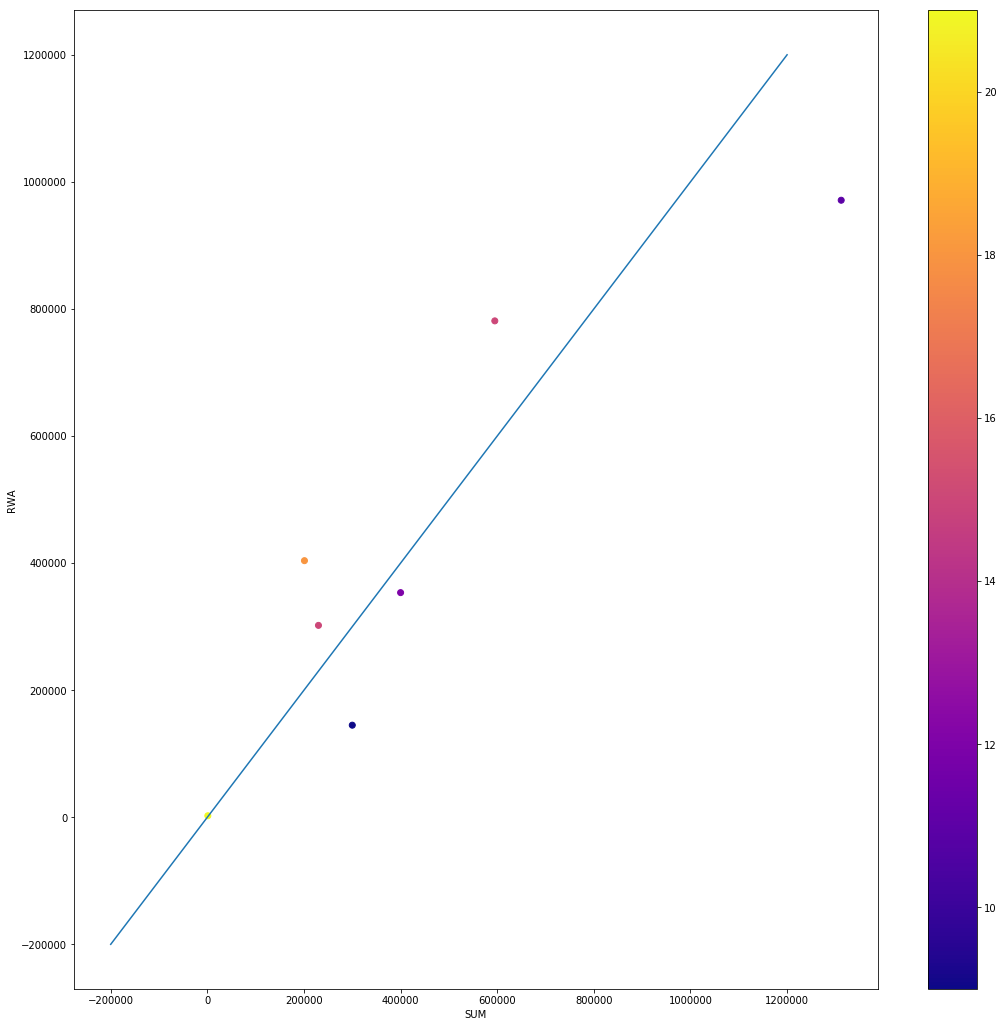

In [49]:
plt.figure(figsize=(18, 18))
plt.scatter(d['sum'], d['RWA'], c=d['rating'], cmap=cm)
plt.colorbar()
plt.ylabel('RWA')
plt.xlabel('SUM')

plt.plot([-200000, 1200000], [-200000, 1200000])
plt.show()
#отношение RWA к сумме кредита видно на графике